In [ ]:
# -*- coding: utf-8 -*-
"""
@author: sara-
Concept: Preprocessing data and saving it in a csv file
Specify absolute path for saving the datain the last cell

"""

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('twcs.csv')
print('Variables and datatypes\n')
df.info()
print('\nVariables with null values')
display(df.isnull().any())
df.tail()

Variables and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB

Variables with null values


tweet_id                   False
author_id                  False
inbound                    False
created_at                 False
text                       False
response_tweet_id           True
in_response_to_tweet_id     True
dtype: bool

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0
2811773,2987950,823870,True,Tue Nov 21 22:01:04 +0000 2017,@AldiUK warm sloe gin mince pies with ice cre...,"2987951,2987949",NaN


In [5]:
# Data preprocessing
# Cleaning tweets text
# Remove @ mentions, hashtags, RT(even though it shoudnt have any) and hyperlinks using regular expressions
def text_preprocessing(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text) 
    return text

# Lowercase
def to_lower(text):
    return text.lower()

# Punctuations
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))
    #return re.sub(r'[^\w\s]','', text) 

In [6]:
# Remove emojis
def remove_emojis(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emojis.sub(r'', text)

In [7]:
from spellchecker import SpellChecker
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [8]:
df['text'] = df['text'].apply(text_preprocessing)
df["text"] = df["text"].apply(remove_punctuations)
df["text"] = df["text"].apply(to_lower)
df["text"] = df["text"].apply(remove_emojis)

In [9]:
#df["text"] = df["text"].apply(correct_spellings)
df['text'].tail()

2811769     hey wed be happy to look into this for you pl...
2811770     wtf i’ve been having really shitty service al...
2811771      you have to go to  and ask them to add the h...
2811772                             sounds delicious sarah  
2811773      warm sloe gin mince pies with ice cream  the...
Name: text, dtype: object

In [10]:
df_inbounds = df.loc[df['inbound'] == True]
df_outbounds = df.loc[df['inbound'] == False]
df_outbounds.tail()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2811764,2987943,AirAsiaSupport,False,Wed Nov 22 07:54:57 +0000 2017,sorry but kindly try to clear browsercachecoo...,NaN,2987944.0
2811766,139628,ArgosHelpers,False,Wed Nov 22 08:03:26 +0000 2017,can you dm us your order number and we can lo...,NaN,139627.0
2811767,2987945,VirginTrains,False,Wed Nov 22 08:27:34 +0000 2017,thats a peak service the 0956 is the first of...,NaN,2987946.0
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,hey wed be happy to look into this for you pl...,NaN,2987948.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,sounds delicious sarah,NaN,2987950.0


In [11]:
#Get only data from AppleSupport and AmazonCares 
#@applesupport => 3309375033, @amazonhelp => 85741735, @spotifycares => 497340309

df_apple = df[(df['author_id'] == 3309375033) | (df['author_id'] == 'AppleSupport' )]
df_amazon = df[(df['author_id'] == 85741735) | (df['author_id'] == 'AmazonHelp')]
df_spotify = df[(df['author_id'] == 497340309) | (df['author_id'] == 'SpotifyCares')]

df_apple.tail()
df_amazon.tail()
df_spotify.tail()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2811209,2987393,SpotifyCares,False,Thu Nov 30 07:37:20 +0000 2017,hi weve just sent a dm your way lets carry on...,NaN,2987394.0
2811211,2987395,SpotifyCares,False,Thu Nov 30 07:35:46 +0000 2017,hey thomas helps here can you dm us your acco...,2987396,2987397.0
2811214,2987398,SpotifyCares,False,Thu Nov 30 07:34:24 +0000 2017,can you send us a dm with your accounts email...,NaN,2987399.0
2811216,2987400,SpotifyCares,False,Thu Nov 30 07:29:24 +0000 2017,hey benedict can you dm us yours and your fam...,NaN,2987401.0
2811503,2987684,SpotifyCares,False,Tue Oct 31 22:03:05 +0000 2017,hey paul could you dm us your accounts userna...,NaN,2987685.0


In [118]:
# Data visualization: How do this companies comunicate with users?
# Wordclouds
textWords_apple = ''.join(tweets for tweets in df_apple['text'])
textWords_amazon = ''.join(tweets for tweets in df_amazon['text'])
textWords_spotify = ''.join(tweets for tweets in df_spotify['text'])

wordcloud1 = WordCloud(width = 1000, height = 800, random_state = 21, max_font_size = 110).generate(textWords_apple)
wordcloud2 = WordCloud(width = 1000, height = 800, random_state = 21, max_font_size = 110).generate(textWords_amazon)
wordcloud3 = WordCloud(width = 1000, height = 800, random_state = 21, max_font_size = 110).generate(textWords_spotify)

In [ ]:
# How does users comunicate with all the companies?
textWords_inbounds = ''.join(tweets for tweets in df_inbounds['text'])
wordcloud4 = WordCloud(width = 1000, height = 800, random_state = 21, max_font_size = 110).generate(textWords_inbounds)

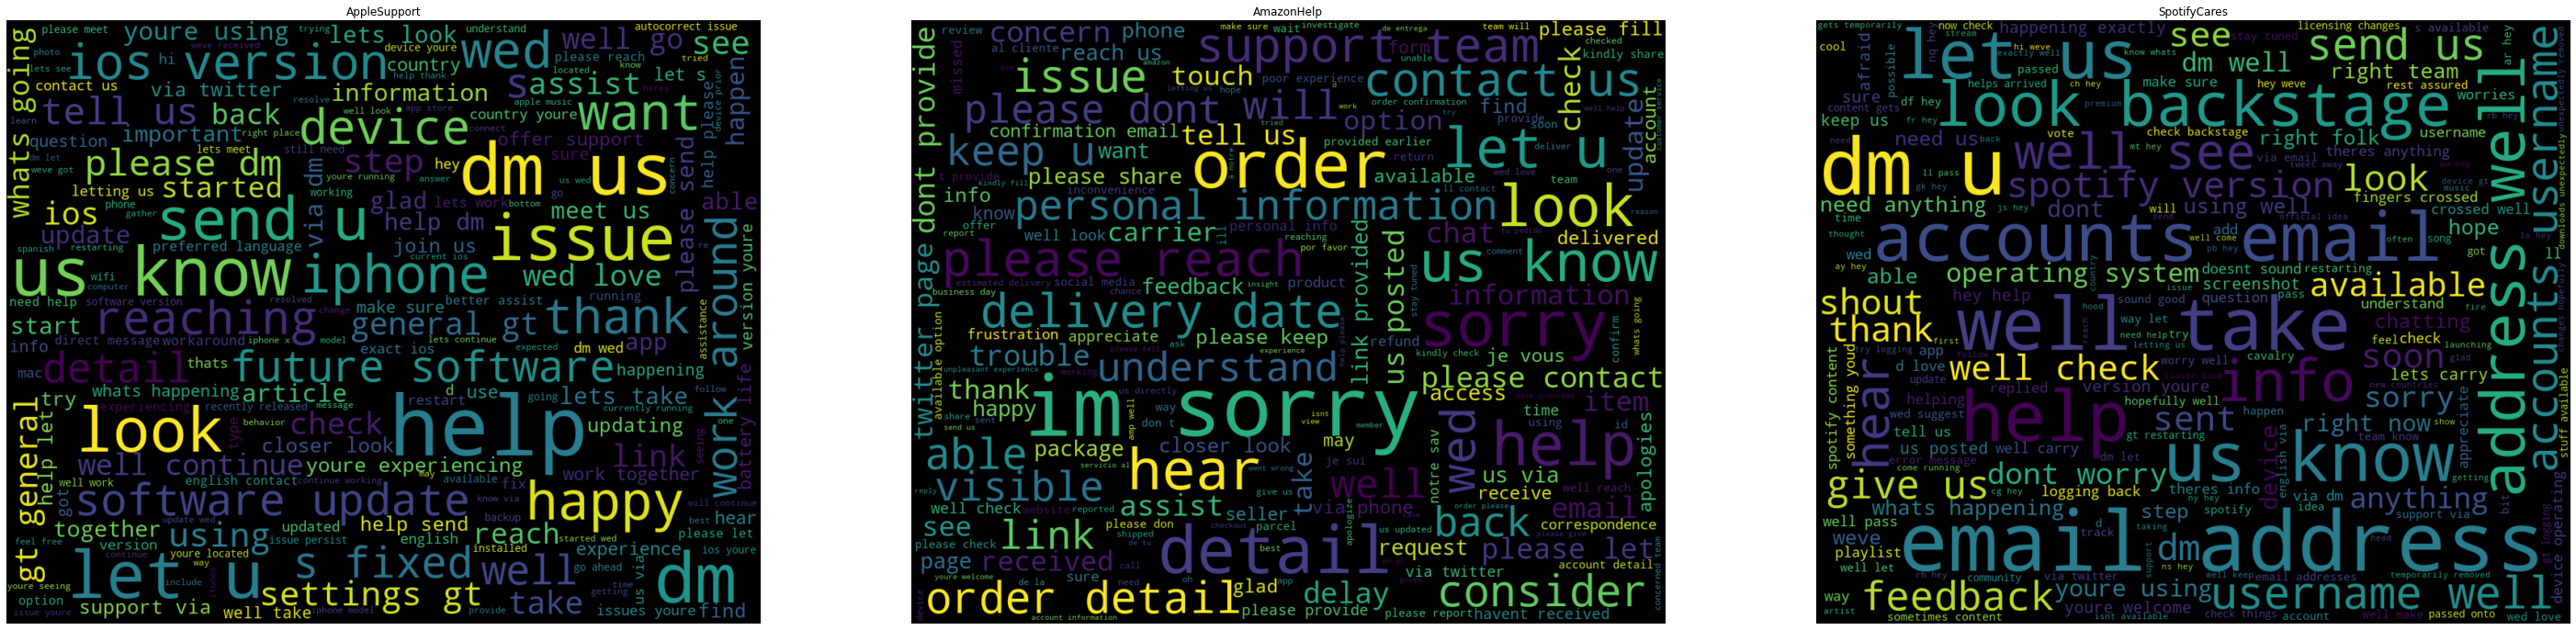

In [119]:
#Figures
fig = plt.figure(figsize=(50, 50))
rows = 1
columns = 3

#Apple
fig.add_subplot(rows, columns, 1)
plt.imshow(wordcloud1, interpolation= "bilinear")
plt.title("AppleSupport")
plt.axis('off')
  
# Amazon
fig.add_subplot(rows, columns, 2)
plt.imshow(wordcloud2, interpolation= "bilinear")
plt.title("AmazonHelp")
plt.axis('off')
  
# Spotify
fig.add_subplot(rows, columns, 3)
plt.imshow(wordcloud3, interpolation= "bilinear")
plt.title("SpotifyCares")
plt.axis('off')

plt.show()

In [ ]:
# Inbounds
plt.imshow(wordcloud2, interpolation= "bilinear")
plt.title("Inbounds")
plt.axis('off')

plt.show()

In [12]:
# Save csv data in train_data directory
df_apple.to_csv (r'\Data\apple_preprocessed_data.csv', index = False, header=True)
df_amazon.to_csv (r'\Data\amazon_preprocessed_data.csv', index = False, header=True)
df_spotify.to_csv (r'\Data\spotify_preprocessed_data.csv', index = False, header=True)

In [13]:
df_inbounds.to_csv (r'\Data\inbounds_data.csv', index = False, header=True)
df_outbounds.to_csv (r'\Data\outbounds_data.csv', index = False, header=True)
df.to_csv (r'\Data\all_data.csv', index = False, header=True)